# Data Scientist Professional Case Study

### Company Background

Snow Cone Games are a digital retailer for video games. The website includes a simple filter for the genre of the game as well as more advanced filtering. The product manager has recently learned that only 23% of buyers search for games using the genre filter. 

71% of buyers use advanced filters to find the types of games that appeal to them. The product manager hopes that new categories based on different game attributes can help players find what they are looking for faster.


### Customer Question

The product manager would like to know:
- Can you use the data from 40,000 games to identify groupings of games that are most similar to each other?


### Success Criteria

Ideally, there would be no more than five groupings. Any more would make it much harder to display on the page so there would need to be a good reason to have more.


### Dataset

The data you will use for this analysis can be accessed here: `"data/video_games.csv"`

In [189]:
#Import libraries
import pandas as pd
import missingno as msno
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from scipy.cluster.vq import whiten
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.cluster.vq import kmeans, vq


In [190]:
#Create path as variable
file = "data/video_games.csv"

#Create dataframe
df = pd.read_csv(file)

#print first 10 rows
print(df.head(10))


                                         name  release_date  \
0                                        DOOM  May 12, 2016   
1               PLAYERUNKNOWN'S BATTLEGROUNDS  Dec 21, 2017   
2                                  BATTLETECH  Apr 24, 2018   
3                                        DayZ  Dec 13, 2018   
4                                  EVE Online   May 6, 2003   
5  Grand Theft Auto V: Premium Online Edition           NaN   
6                             Devil May Cry 5   Mar 7, 2019   
7                            Human: Fall Flat  Jul 22, 2016   
8                           They Are Billions  Dec 12, 2017   
9                        Warhammer: Chaosbane  May 31, 2019   

             developer  achievements original_price percent_positive  \
0          id Software          54.0         $19.99              92%   
1     PUBG Corporation          37.0         $29.99              49%   
2  Harebrained Schemes         128.0         $39.99              71%   
3  Bohemia Interac

# Data Validation

In [191]:
#Inspect the shape the data
print(df.shape)

#Inspect the data types of data
print(df.dtypes)

(40833, 9)
name                 object
release_date         object
developer            object
achievements        float64
original_price       object
percent_positive     object
num_reviews         float64
multiplayer          object
mature                 bool
dtype: object


name                   16
release_date         3179
developer             343
achievements        28639
original_price       5311
percent_positive    23470
num_reviews         23470
multiplayer           520
mature                  0
dtype: int64


<AxesSubplot:>

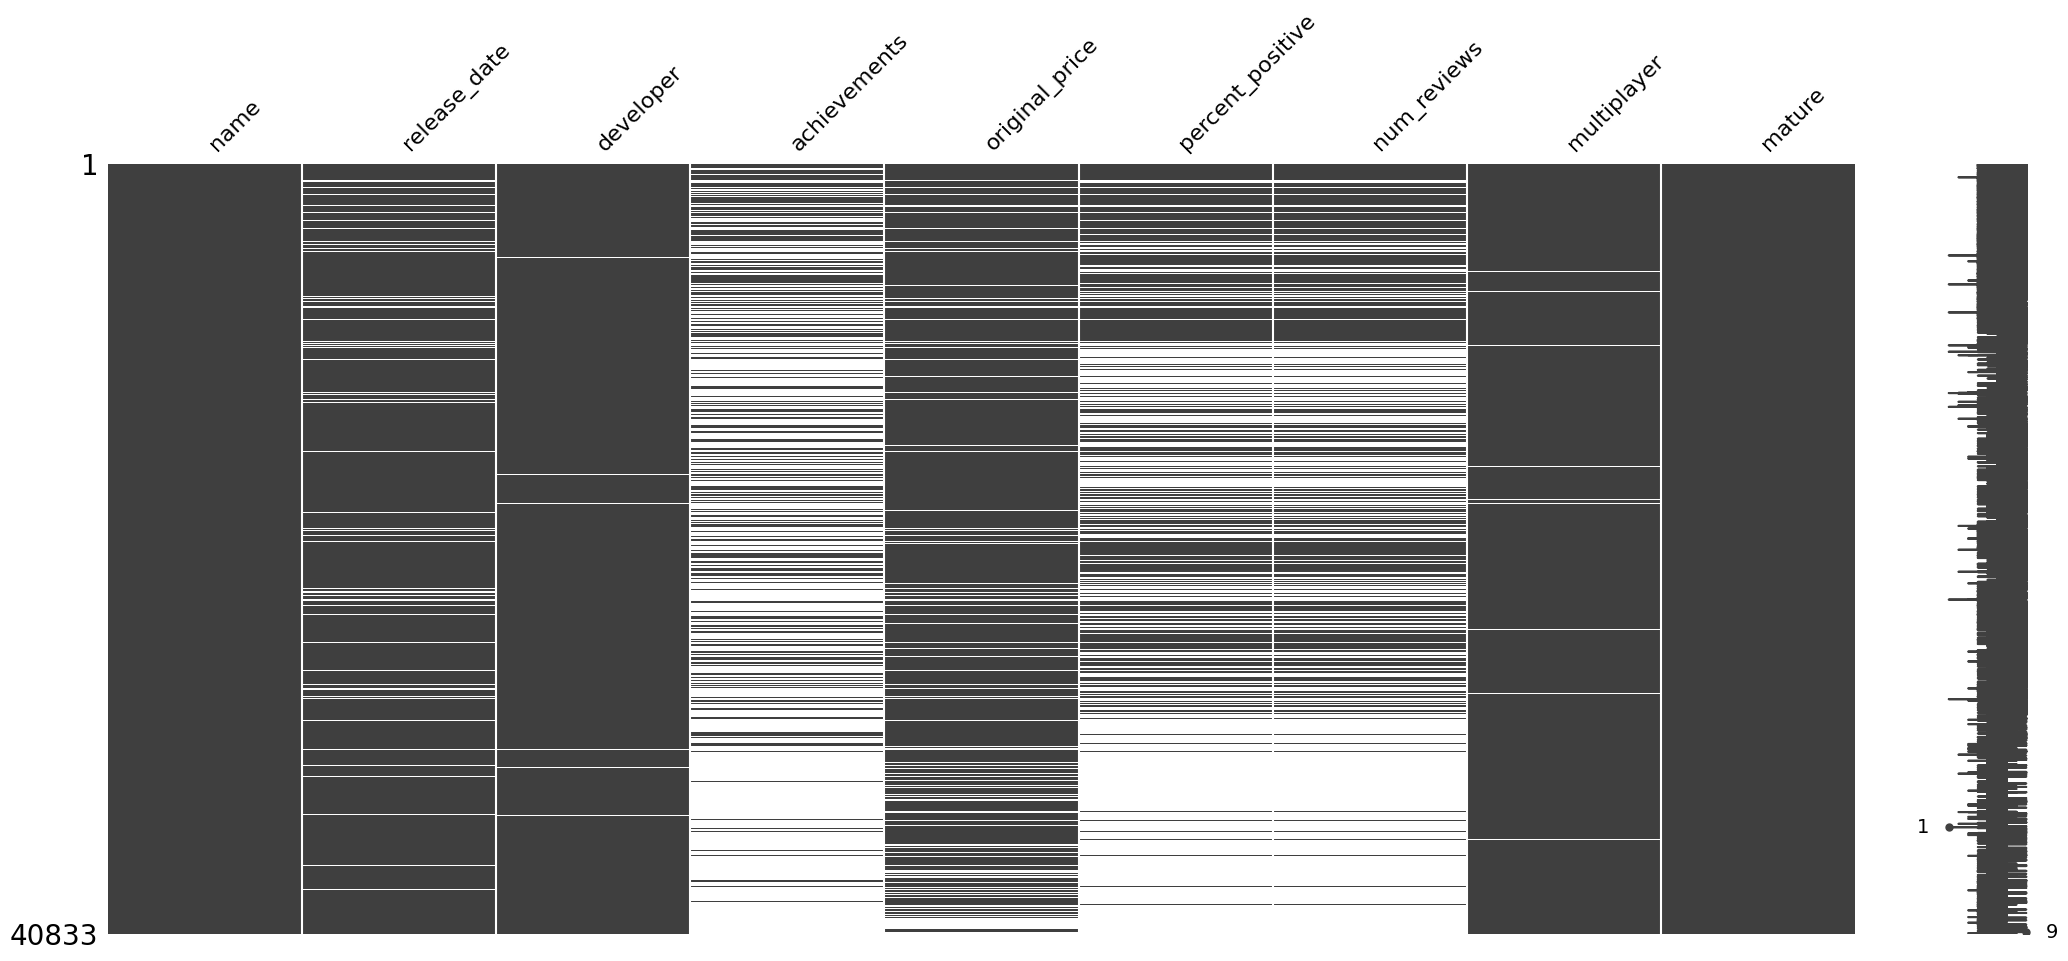

In [192]:
#Check for missing values
print(df.isna().sum())

#Create msno matrix to visualize missing values
msno.matrix(df)

As we can observe there are a lot of missing values in achievements, percent_positive, num_reviews. For simplicity purposes we will drop all missing values as we want to create a model using this columns. The white spaces represent missing values

In [193]:
#Drop missing values
df.dropna(axis = 0, inplace=True)

#Check missing values
print(df.isna().sum())

#Shape of df after droping missing values
print(df.shape)

#Check data types of df
print(df.dtypes)

name                0
release_date        0
developer           0
achievements        0
original_price      0
percent_positive    0
num_reviews         0
multiplayer         0
mature              0
dtype: int64
(8840, 9)
name                 object
release_date         object
developer            object
achievements        float64
original_price       object
percent_positive     object
num_reviews         float64
multiplayer          object
mature                 bool
dtype: object


We also look for duplicated values, first all with the condition all column values of row are duplicated

In [194]:
#Check number of dumplicated values
print(df.duplicated().sum())

#Check the duplicated row
print(df[df.duplicated()])

#Drop duplicated row
df.drop_duplicates(inplace=True)

#Check it was dropped
print(df[df.duplicated()])

1
                                                 name release_date  \
17442  Batman: Arkham City - Game of the Year Edition  Sep 7, 2012   

                                        developer  achievements  \
17442  Rocksteady Studios,Feral Interactive (Mac)          64.0   

      original_price percent_positive  num_reviews multiplayer  mature  
17442         $19.99              94%      17335.0       False   False  
Empty DataFrame
Columns: [name, release_date, developer, achievements, original_price, percent_positive, num_reviews, multiplayer, mature]
Index: []


Quick check of names duplicated

In [195]:
#Duplicated names
print(df[df.duplicated('name', keep = False)].sort_values('name'))

                 name  release_date                        developer  \
18862           Ashes  Oct 26, 2018                        WindLimit   
25300           Ashes  Jun 28, 2017                     FurGoldGames   
24055       Mars 2030  Mar 11, 2016                       Advent RPG   
26241       Mars 2030  Jul 31, 2017                         FMG Labs   
615              RUSH  Jul 13, 2018                  The Binary Mill   
7567             RUSH   Dec 3, 2010                       Two Tribes   
8024   Ultimate Arena  Aug 22, 2016                        Triverske   
23995  Ultimate Arena   Sep 5, 2016  Kenneth Caselli,Gianmarco Rocco   

       achievements original_price percent_positive  num_reviews multiplayer  \
18862          30.0          $3.99              72%         11.0       False   
25300          11.0          $0.99              64%         34.0       False   
24055          23.0          $4.99              45%         33.0       False   
26241          10.0         $14

We will keep this ones as the developer and year are different

In [196]:
#Print final shape of df
print(df.shape)

(8839, 9)


The data set contains now 8839 rows and 9 columns, we now inspect if the data types of the columns are in line with the values:

-    name: object type, actual values string. OK
-    release_date: object type, actual values dates. NOT OK convert to int to for model purposes
-    developer: object type, actual values string. OK
-    achievements: float64, actual values int. NOT OK convert to int
-    original_price: object, actual values numeric NOT OK strings and char values convert to float
-    percent_positive: object, actual values percentages, NOT OK convert to int
-    num_reviews: float64, actual values ints, NOT OK convert to int
-    multiplayer: object, actual values bool, NOT OK convert to bool
-    mature: bool, actual value bool, OK   
    

In [197]:
#Take a look to release_date values
print(df['release_date'][:100])

#Extract the year of release date in a new colum as an int
df['release_year'] = df['release_date'].apply(lambda x: int(str(x)[-4:]))

#Print the result
print(df['release_year'][:100])

0      May 12, 2016
1      Dec 21, 2017
2      Apr 24, 2018
6       Mar 7, 2019
7      Jul 22, 2016
           ...     
153    Aug 29, 2018
154     Jun 4, 2019
155     Apr 5, 2016
157    Dec 15, 2014
158    Dec 14, 2015
Name: release_date, Length: 100, dtype: object
0      2016
1      2017
2      2018
6      2019
7      2016
       ... 
153    2018
154    2019
155    2016
157    2014
158    2015
Name: release_year, Length: 100, dtype: int64


Inspect and transform achievements into int

In [198]:
#Inspect achievements col
print(df['achievements'][:100])

#Transform into int
df['achievements'] = df['achievements'].astype('int') 

#Check result
print(df['achievements'][:100])

0       54.0
1       37.0
2      128.0
6       51.0
7       55.0
       ...  
153     56.0
154    100.0
155     11.0
157    361.0
158     39.0
Name: achievements, Length: 100, dtype: float64
0       54
1       37
2      128
6       51
7       55
      ... 
153     56
154    100
155     11
157    361
158     39
Name: achievements, Length: 100, dtype: int64


In [199]:
#Take a look at original price column
print(df['original_price'][:100])

#Replace all non numeric characters using regex
df['original_price'] = df['original_price'].apply(lambda x: re.findall(r"[-+]?(?:\d*\.\d+|\d+)", str(x)))
print(df['original_price'][:100])

0            $19.99
1            $29.99
2            $39.99
6            $59.99
7            $14.99
           ...     
153          $19.99
154           $9.98
155          $19.99
157           $4.99
158    Free to Play
Name: original_price, Length: 100, dtype: object
0      [19.99]
1      [29.99]
2      [39.99]
6      [59.99]
7      [14.99]
        ...   
153    [19.99]
154     [9.98]
155    [19.99]
157     [4.99]
158         []
Name: original_price, Length: 100, dtype: object


Now our column is filled with lists which values are either a float or an empty list, lets replace empty lists with 0.0 and convert to float 

In [200]:
#Extract values as float creating a new list
df['original_price'] = [float(x[0]) if len(x) > 0 else '0.0' for x in df['original_price']]

#Change column data type to float
df['original_price'] = df['original_price'].astype('float64') 
print(df['original_price'][:100])


0      19.99
1      29.99
2      39.99
6      59.99
7      14.99
       ...  
153    19.99
154     9.98
155    19.99
157     4.99
158     0.00
Name: original_price, Length: 100, dtype: float64


Inspect and convert percentage_positive to int

In [201]:
#Take a look at original percentage_positive column
print(df['percent_positive'][:100])

#Convert replace white spaces and % symbol and convert to int
df['percent_positive'] = df['percent_positive'].str.replace('%','').str.strip().astype('int')

#Print column
print(df['percent_positive'][:100])

0      92%
1      49%
2      71%
6      92%
7      91%
      ... 
153    64%
154    94%
155    83%
157    86%
158    52%
Name: percent_positive, Length: 100, dtype: object
0      92
1      49
2      71
6      92
7      91
       ..
153    64
154    94
155    83
157    86
158    52
Name: percent_positive, Length: 100, dtype: int64


Convert num_reviews to int

In [202]:
#Inspect num_reviews
print(df['num_reviews'][:100])

#Convert to int
df['num_reviews'] = df['num_reviews'].astype(int)

#Print result
print(df['num_reviews'][:100])

0       42550.0
1      836608.0
2        7030.0
6        9645.0
7       23763.0
         ...   
153     22177.0
154       617.0
155       823.0
157     13158.0
158      2827.0
Name: num_reviews, Length: 100, dtype: float64
0       42550
1      836608
2        7030
6        9645
7       23763
        ...  
153     22177
154       617
155       823
157     13158
158      2827
Name: num_reviews, Length: 100, dtype: int64


In [203]:
#Inspect values of multiplayer
print(df['multiplayer'].value_counts())

#Convert to bool
df['multiplayer'] = df['multiplayer'].astype('bool')

#Print result
print(df['multiplayer'][:100])

False    6793
True     2046
Name: multiplayer, dtype: int64
0       True
1       True
2       True
6       True
7       True
       ...  
153     True
154    False
155    False
157     True
158     True
Name: multiplayer, Length: 100, dtype: bool


Lets get rid of the release_date column and check that all column dtypes are now Ok and we dont have missing values

In [204]:
#Drop the release date column
df.drop('release_date', axis = 1, inplace = True)

#Check the 
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8839 entries, 0 to 40728
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              8839 non-null   object 
 1   developer         8839 non-null   object 
 2   achievements      8839 non-null   int64  
 3   original_price    8839 non-null   float64
 4   percent_positive  8839 non-null   int64  
 5   num_reviews       8839 non-null   int64  
 6   multiplayer       8839 non-null   bool   
 7   mature            8839 non-null   bool   
 8   release_year      8839 non-null   int64  
dtypes: bool(2), float64(1), int64(4), object(2)
memory usage: 569.7+ KB
None


### Data Validation Summary
    
    The following changes have been made to our data:
- Dropped all the missing values
- Dropped all duplicated values while keeping duplicated names as they were from different developers
- Change the data type and cleaned they following columns
    -    release_date: converted to int
    -    achievements: converted to int
    -    original_price: converted to float and replaced strings containing 'free' for 0.0
    -    percent_positive: converted to int
    -    num_reviews: converted to int
    -    multiplayer: converted to bool
- Dropped the release_date column and created release_year column instead

# Data Visualization

Next step is start our data visualization process, first we will analyze the numeric columns data with summary statistics

In [205]:
#Summary statistics
print(df.describe())

       achievements  original_price  percent_positive    num_reviews  \
count   8839.000000     8839.000000       8839.000000    8839.000000   
mean      93.168911       92.271940         76.529472    1935.599163   
std      510.335923     6919.749555         16.892449   15353.187837   
min        1.000000        0.000000          0.000000      10.000000   
25%       13.000000        2.990000         67.000000      28.000000   
50%       24.000000        9.990000         80.000000     101.000000   
75%       42.000000       14.990000         90.000000     489.000000   
max     9821.000000   650560.000000        100.000000  836608.000000   

       release_year  
count   8839.000000  
mean    2016.186333  
std        2.402479  
min     1983.000000  
25%     2015.000000  
50%     2017.000000  
75%     2018.000000  
max     2019.000000  


First we can spot outliers in achievements, original price, num_review, so lets get deeper in our analysis by seeing how the values are distributed and if this outliers make sense so we can drop the ones that doesn't while keeping the maximum information possible of our data set

Lets start witch achievements, as we can see the range of the data is very wide, ranges from 1 to 9821, with an 510 standard deviation value, we will need to use logarithmic scale of the data in order to better visualize how its distributed, but lets make a first look of the data

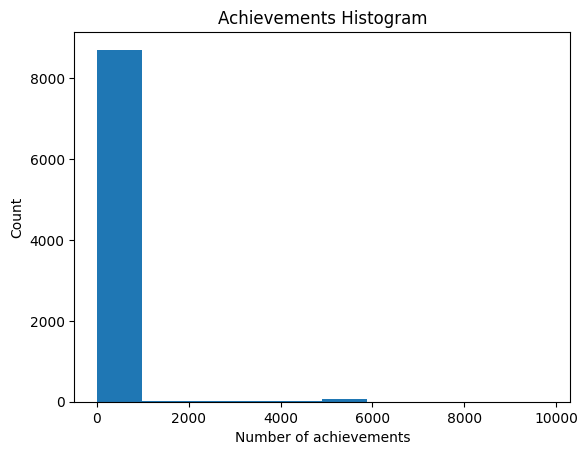

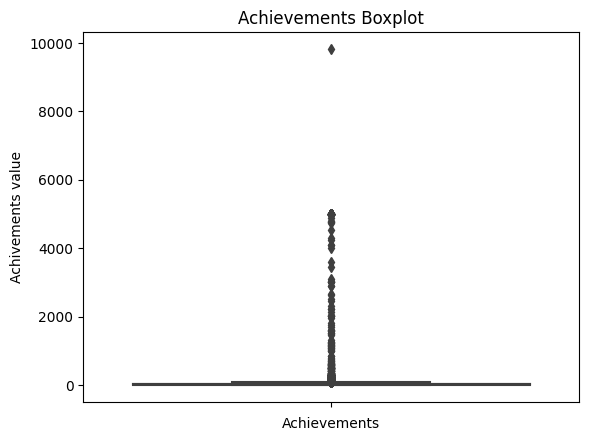

In [206]:
#Extract achievements column
achievements = df['achievements']

#Plot achievements
#Create histogram
plt.hist(achievements)
plt.title('Achievements Histogram')
plt.xlabel('Number of achievements')
plt.ylabel('Count')
plt.show()

#Create boxplot
sns.boxplot(y = achievements)
plt.title('Achievements Boxplot')
plt.xlabel('Achievements')
plt.ylabel('Achivements value')
plt.show()

As we can see, both the histogram and box plot shows little information of the distribution values, we can see that there are a large number of outliers though, lets re-scale the data to logarithmic for a better visualization  

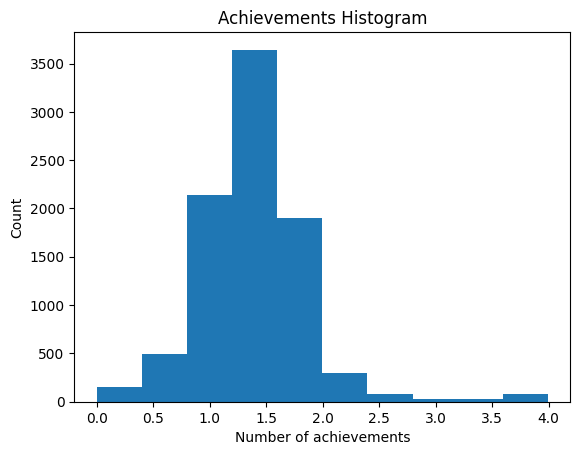

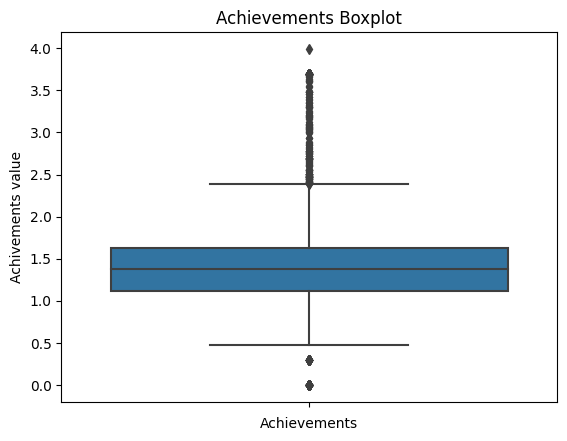

In [207]:
#Reescale the data
achievements = np.log10(df['achievements'])

#Plot achievements
#Create histogram
plt.hist(achievements)
plt.title('Achievements Histogram')
plt.xlabel('Number of achievements')
plt.ylabel('Count')
plt.show()

#Create boxplot
sns.boxplot(y = achievements)
plt.title('Achievements Boxplot')
plt.xlabel('Achievements')
plt.ylabel('Achivements value')
plt.show()

It seems to be a large number of outliers in achievements lets inspect how many there are, also lets create a function for repeating this process for the rest of numeric data if necessary

In [208]:
#Define a function to see how many outliers there are and the percentage of total
def outliers(df, column):
    """Function to calculate the number of outliers and their % over data
    
    arg1(df): pandas dataframe
    arg2(column): string
    
    returns: List [number of outliers, % of outliers, outlier point]
    """
    results = []
    
    #Calculate percentile 25
    Q1 = np.nanpercentile(df[column] , 25)
    
    #Calculate percentile 75
    Q3 = np.nanpercentile(df[column], 75)
    
    #Calculate IQR
    IQR = Q3 -Q1
    
    #Calculate outlier point
    outlier_point = IQR * 1.5
    
    #Filter by outliers
    outliers_col = df[(df[column] > Q3 + outlier_point) | (df[column] < Q1 - outlier_point)]
    
    #Number of outliers
    n_outliers = len(outliers_col)
    results.append(n_outliers)
    
    #% of outliers
    p_outliers = n_outliers/(len(df)
    results.append(p_outliers)
    
    #Append to list
    results.append(outlier_point)
    
    return results

Now that we have the outlier function lets see how many there are in achievements

In [209]:
#Use our function to return number, percentage and the outlier point
ach_out = outliers(df, 'achievements')

#Print result
print(ach_out)

[644, 0.07285892069238602, 43.5]


As we can see there are 644 outliers which represent about 7.3% of total, lets see if this outliers make sense by looking at their distribution, we will look at the top ones, as per the plot there are only a few below in the low range

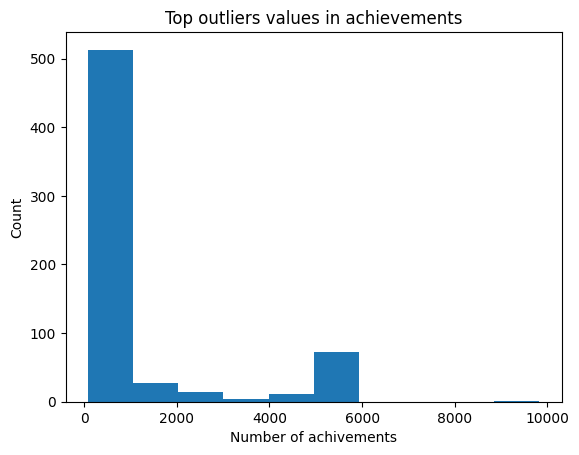

In [210]:
#Filter by top outliers
df_top_out = df[df['achievements'] > np.nanpercentile(df['achievements'], 75) + ach_out[2]]

#Select outliers
top_outliers = df_top_out['achievements']

#Plot outliers distribution
plt.hist(top_outliers)
plt.xlabel('Number of achivements')
plt.ylabel('Count')
plt.title('Top outliers values in achievements')
plt.show()

As we can see in this and previous charts there is an spike in the 5000 value, which most likely is an error, as well as values above that mark, lets set a threshold of 1000 thousand and drop the rest, and check again our outlier values and percentage

In [211]:
#Get the index of 1000 value achievements
idx_out = df[df['achievements'] >= 1000].index

#Drop by index the games
df.drop(idx_out, inplace=True)

#Use our function to return number, percentage and the outlier point
ach_out = outliers(df, 'achievements')

#Print result
print(ach_out)

[575, 0.06605399195864446, 40.5]


The data remains with 575 outliers which represent 6.6% of the total data, once again we visualize the results, and its summary statistics using a logarithmic scale

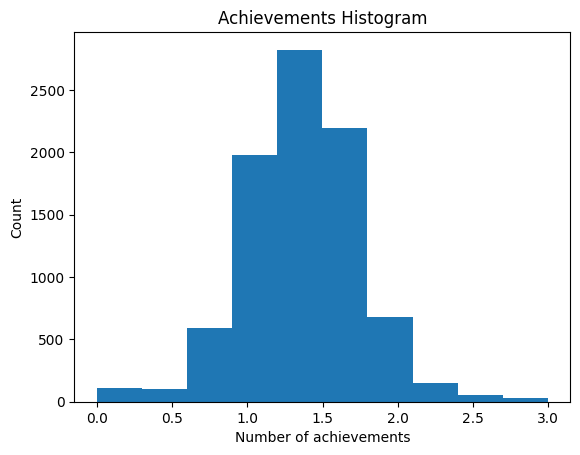

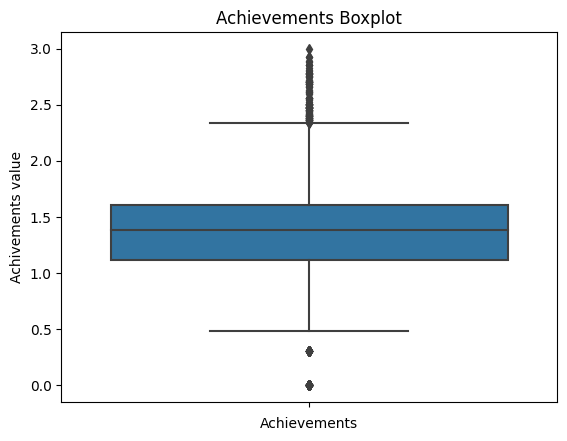

count    8705.000000
mean       35.212062
std        51.770106
min         1.000000
25%        13.000000
50%        24.000000
75%        40.000000
max       995.000000
Name: achievements, dtype: float64


In [212]:
#Reescale the data
achievements = np.log10(df['achievements'])

#Plot achievements
#Create histogram
plt.hist(achievements)
plt.title('Achievements Histogram')
plt.xlabel('Number of achievements')
plt.ylabel('Count')
plt.show()

#Create boxplot
sns.boxplot(y = achievements)
plt.title('Achievements Boxplot')
plt.xlabel('Achievements')
plt.ylabel('Achivements value')
plt.show()

#Summary statistics
print(df['achievements'].describe())

Data now looks like is normally distributed, we reduced the std to 51.7, the mean of the distribution is 35.2, and the range now makes more sense.
Now we will perform the same analysis for prices, firs we will take a first look having in mind the presence of outliers as well, remember that the range of original_price goes from 0 to 650560  

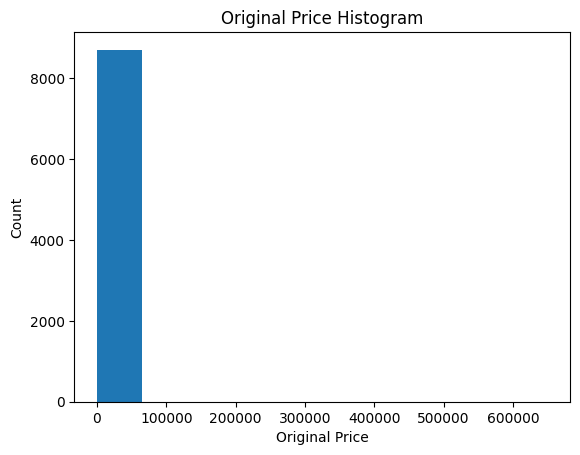

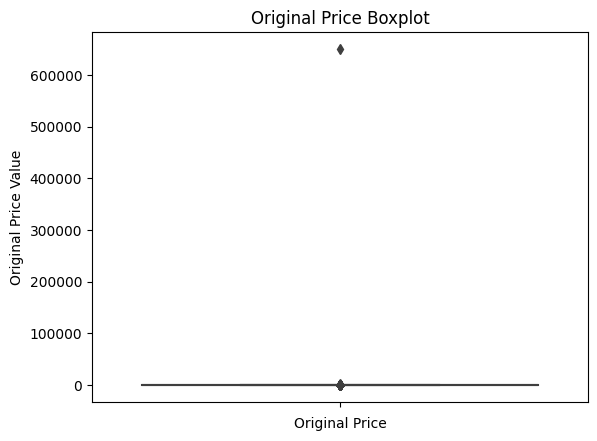

In [213]:
#Extract prices column
prices = df['original_price']

#Plot prices
#Create histogram
plt.hist(prices)
plt.title('Original Price Histogram')
plt.xlabel('Original Price')
plt.ylabel('Count')
plt.show()

#Create boxplot
sns.boxplot(y = prices)
plt.title('Original Price Boxplot')
plt.xlabel('Original Price')
plt.ylabel('Original Price Value')
plt.show()

Lets use our function to quantify how many outliers there are

In [214]:
#Use our function to return number, percentage and the outlier point
price_out = outliers(df, 'original_price')
#Print result
print(price_out)

[572, 0.06570936243538196, 18.0]


As we can see there are about 572 outliers or 6,6% of the data, lets use a reasonable threshold of 90 (special edition games can cost around this value) for the price and drop them

In [215]:
#Get the index of 100 theshold
idx_out = df[df['original_price'] >= 90].index

#Drop by index the games
df.drop(idx_out, inplace=True)

Lets plot again prices and its summary statistics and see if values make sense

[433, 0.05054868083119309, 18.0]


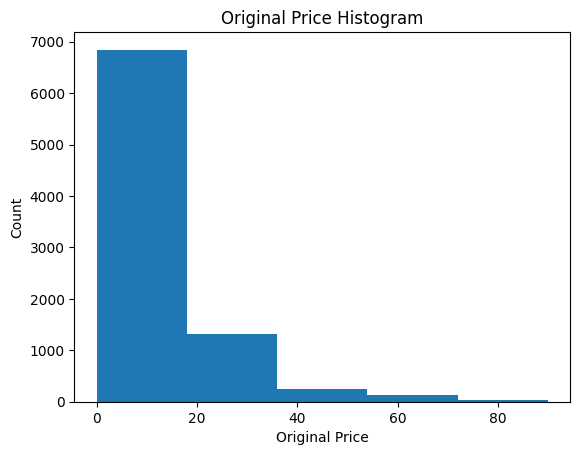

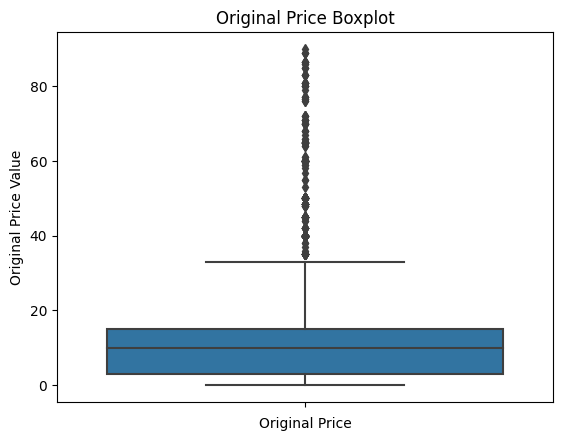

count    8566.000000
mean       11.466498
std        12.261958
min         0.000000
25%         2.990000
50%         9.990000
75%        14.990000
max        89.950000
Name: original_price, dtype: float64


In [216]:
#Use our function to return number, percentage and the outlier point
price_out = outliers(df, 'original_price')
#Print result
print(price_out)

#Extract prices column
prices = df['original_price']

#Plot prices
#Create histogram
plt.hist(prices, bins = 5)
plt.title('Original Price Histogram')
plt.xlabel('Original Price')
plt.ylabel('Count')
plt.show()

#Create boxplot
sns.boxplot(y = prices)
plt.title('Original Price Boxplot')
plt.xlabel('Original Price')
plt.ylabel('Original Price Value')
plt.show()

#Print summary statistics
print(df['original_price'].describe())

The data between the 25 and the 75 percentile is between 0 and 16 dollars price range, the mean its 11.46 and the standard deviation is 12.26 quite logic values. The price distribution makes sense as per market conditions(mobile games, independent studios, ect), we will keep the rest of outliers as they are most like quality data (most of the so called AAA games are above 40 dollars) and we want to loose less information as possible.

Lets check again our numeric columns summary statistics

In [217]:
#Summary statistics
print(df.describe())

       achievements  original_price  percent_positive    num_reviews  \
count   8566.000000     8566.000000       8566.000000    8566.000000   
mean      35.069577       11.466498         76.651062    1961.908709   
std       51.074839       12.261958         16.868753   15421.100636   
min        1.000000        0.000000          0.000000      10.000000   
25%       13.000000        2.990000         68.000000      29.000000   
50%       23.000000        9.990000         80.000000     104.000000   
75%       40.000000       14.990000         90.000000     502.750000   
max      995.000000       89.950000        100.000000  836608.000000   

       release_year  
count   8566.000000  
mean    2016.181181  
std        2.410543  
min     1983.000000  
25%     2015.000000  
50%     2017.000000  
75%     2018.000000  
max     2019.000000  


Percent positive shows correct values, range from 0 to 100, and we can observe that has a mean of 76 thus as average games are graded positive, in the case of release_year values are also within a logic range, having the first games in 1983 and last ones in 2019

Number of reviews shows a huge variance and very wide range, although this might be correct, we will analyze also this column using same methodology as before

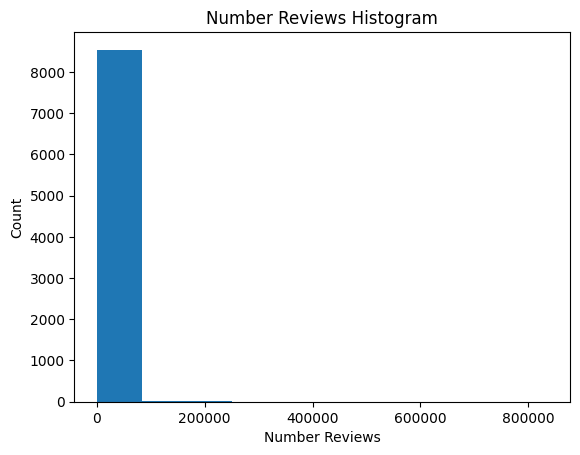

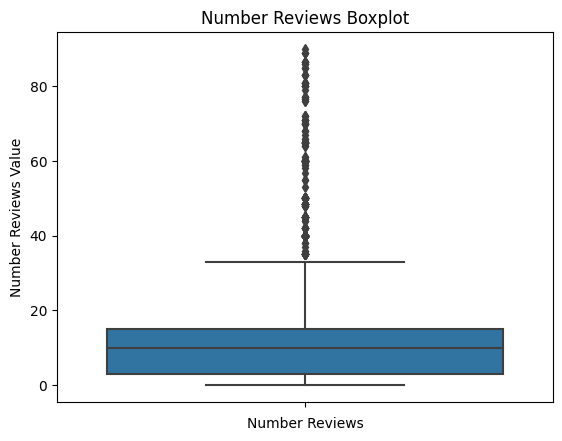

In [218]:
#Extract prices column
reviews = df['num_reviews']

#Plot prices
#Create histogram
plt.hist(reviews)
plt.title('Number Reviews Histogram')
plt.xlabel('Number Reviews')
plt.ylabel('Count')
plt.show()

#Create boxplot
sns.boxplot(y = prices)
plt.title('Number Reviews Boxplot')
plt.xlabel('Number Reviews')
plt.ylabel('Number Reviews Value')
plt.show()

In [219]:
#Use our function to return number, percentage and the outlier point
rev_out = outliers(df, 'num_reviews')
#Print result
print(rev_out)

[1383, 0.16145225309362596, 710.625]


In this case the number of outliers is much bigger 1383 or 16.1% of the data, we can see also that the median is around 12 reviews, now we will dig deeper into this outliers for a better understanding of the values by extracting all of them and inspecting the largest numbers of reviews

In [220]:
#Filter top outliers
reviews_outliers = df[df['num_reviews'] >= np.nanpercentile(df['num_reviews'],75) + rev_out[2]]
#Print outliers
print(reviews_outliers[['name','num_reviews']].sort_values('num_reviews', ascending = False).head(10))

                              name  num_reviews
1    PLAYERUNKNOWN'S BATTLEGROUNDS       836608
386                Team Fortress 2       553458
407             Grand Theft Auto V       407706
661                       Unturned       325675
335                    Garry's Mod       310394
408                       Warframe       250319
406                           Rust       206811
320                      Paladins®       204137
363                       Terraria       201266
410      The Witcher® 3: Wild Hunt       189538


The titles of the 10 largest games show us that the outliers are correct, as these are top world games, so we will keep it all

Lets continue by inspecting the final data for our model

In [221]:
#Print data types, null object, summary statistics and first 5 rows
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8566 entries, 0 to 40728
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              8566 non-null   object 
 1   developer         8566 non-null   object 
 2   achievements      8566 non-null   int64  
 3   original_price    8566 non-null   float64
 4   percent_positive  8566 non-null   int64  
 5   num_reviews       8566 non-null   int64  
 6   multiplayer       8566 non-null   bool   
 7   mature            8566 non-null   bool   
 8   release_year      8566 non-null   int64  
dtypes: bool(2), float64(1), int64(4), object(2)
memory usage: 552.1+ KB
None
       achievements  original_price  percent_positive    num_reviews  \
count   8566.000000     8566.000000       8566.000000    8566.000000   
mean      35.069577       11.466498         76.651062    1961.908709   
std       51.074839       12.261958         16.868753   15421.100636   
min       

As we can see all changes had been effective, and we have a clean dataframe of 8575 rows and 9 columns, with no missing values and all the columns with the correct data type and values

Next step is a brief analysis of relationships between our data regarding numeric columns, we will skip the analysis of string columns as name of developer since we won't be using it in our model

Lets start with a correlation analysis between the numeric columns including boolean, by creating a correlation matrix and a heat map for better visualization

                  achievements  original_price  percent_positive  num_reviews  \
achievements          1.000000        0.079369          0.011550     0.111692   
original_price        0.079369        1.000000          0.022445     0.075499   
percent_positive      0.011550        0.022445          1.000000     0.046266   
num_reviews           0.111692        0.075499          0.046266     1.000000   
multiplayer           0.105558        0.117587         -0.095936     0.106134   
mature               -0.013667        0.051145          0.012058     0.071663   
release_year         -0.036143        0.046088         -0.011509    -0.087592   

                  multiplayer    mature  release_year  
achievements         0.105558 -0.013667     -0.036143  
original_price       0.117587  0.051145      0.046088  
percent_positive    -0.095936  0.012058     -0.011509  
num_reviews          0.106134  0.071663     -0.087592  
multiplayer          1.000000 -0.039859     -0.065049  
mature         

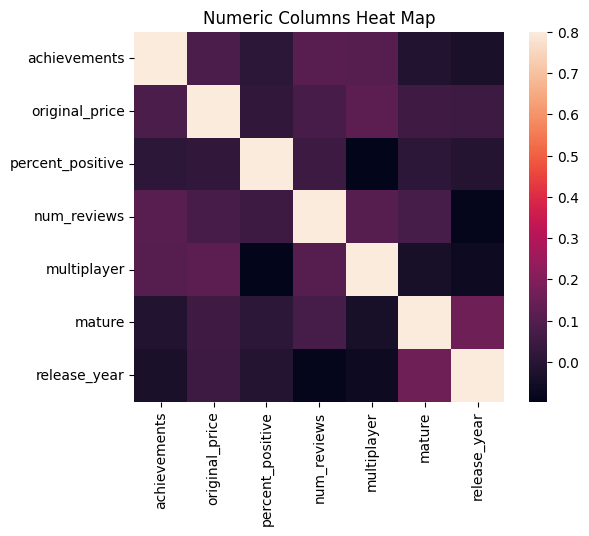

In [222]:
#Extract numeric columns
df_num = df[['achievements','original_price','percent_positive','num_reviews','multiplayer','mature','release_year']]

#Create correlation matrix
corr_mat = df_num.corr()

#Print result
print(corr_mat)

#Creat heat map
sns.heatmap(corr_mat, vmax=0.8, square=True)
plt.title('Numeric Columns Heat Map')
plt.show()

As shown in the matrix and the heatmap our numeric variables have no correlation between them. The correlation value ranges from -1 to 1 being 1 a perfect positive correlation value and -1 same but negative, all our values are around 0 in ranges that represent a lack of correlation.

# Model development

The goal of this project is develop new categories for the games to allow users to find games faster in our web.
After executing the data validation and visualization process we have our data ready to create a model which can generate new categories for the games based on the data our company has.

First we have to determine which type of problem this task is, we can use regression, classification or clustering. 
The task can't be made using regression models the goal its not a continuous variable.
With regards of classification, this is not a classification problem as we don't aim to classify game by gender for example, so our problem needs to be approach with clustering.

We will create two unsupervised learning models for clustering as our objective is to find clusters (categories) in the data by identifying hidden patterns.

We will create KMeans and Hierarchycal clustering models and compare the results

Lets start with the KMeans models


For the models, first we will perform a Principal Component Analysis in order to determine the intrinsic dimension by counting the PCA features with significant variance. In order to do so we will have to transform the columns to arrays, then normalize the data as the values have different scales and create the PCA model


In [223]:
#Extract columns
price = df['original_price']
positive = df['percent_positive']
achievements = df['achievements']
reviews = df['num_reviews']
multiplayer = df['multiplayer']
mature = df['mature']
year = df['release_year']

#Convert columns to array 
achievements_array = achievements.to_numpy() 
price_array = price.to_numpy()
positive_array = positive.to_numpy()
reviews_array = reviews.to_numpy()
multiplayer_array = multiplayer.to_numpy()
mature_array = mature.to_numpy()
year_array = year.to_numpy()

#Stack arrays by column
samples = np.column_stack((price_array, positive_array, reviews_array, multiplayer, mature_array, year, achievements_array))

print(samples.shape)

(8566, 7)


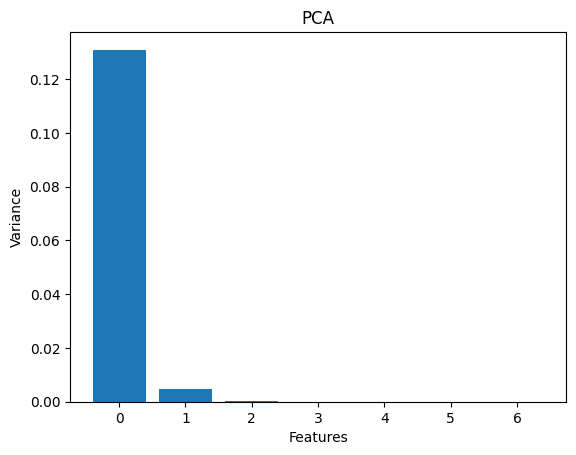

In [224]:
#Instantiate scaler
scaler = Normalizer()

#Transform data
samples_t = scaler.fit_transform(samples)

#Instantiate PCA model
pca = PCA()

#Fit pca model
pca.fit(samples_t)

#Extract the feature number
features = range(pca.n_components_)

#Create the plot of variance per feature
plt.bar(features, pca.explained_variance_)
plt.xlabel('Features')
plt.ylabel('Variance')
plt.title('PCA')
plt.show()

Based on the previous analysis we can observe that a  logic intrinsic dimension will be 2, next step is select two variables for our KMeans model and create it

We will choose original price and positive percent, so we can try to find patterns that show the price/quality relationship, first we will plot a scatter plot to visualize the data, rember that the correlation value for these variables was 0.02

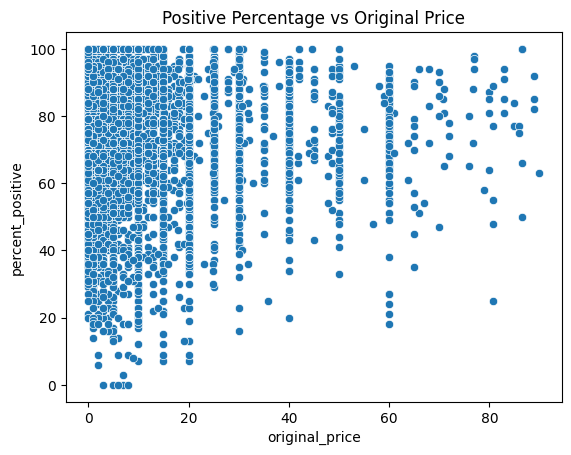

In [225]:
#Create scater plot
sns.scatterplot(price, positive)
plt.title('Positive Percentage vs Original Price')
plt.show()

Now we create the samples array to be fit in the model

In [226]:
#Create samples array
samples = np.column_stack((price_array, positive_array))

#Print shape
print(samples.shape)

(8566, 2)


Next step is to determine the number of clusters that will be used in the model, with a maximum  of 5 clusters, we will do so by using the elbow method which plots the relationship between intertia (which measures how far are the points from centroids) and number of clusters

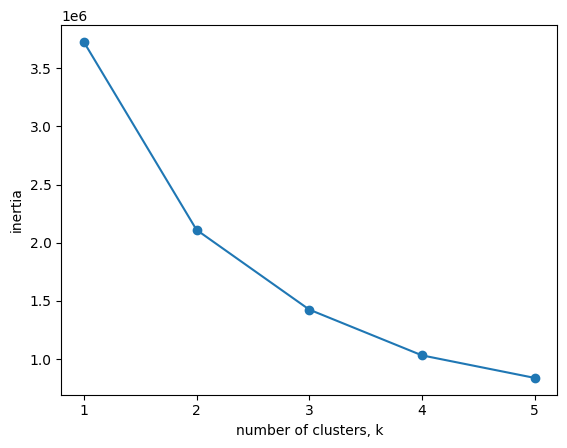

In [227]:
#List of number of clusters
ks = range(1, 6)

#Inertias list
inertias = []

#iterate over clusters, fit model and append inertia values
for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(samples)
    inertias.append(model.inertia_)

#Plot the results
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

We will use 3 clusters for our KMeans model, our process of generating clusters with KMeans consists of:

- Standardize the values
- Generate the clusters centers
- Assign cluster centers to an new column in the dataframe
- Plot the results



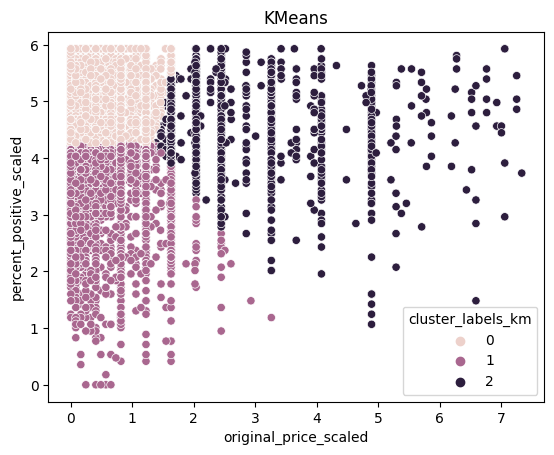

In [228]:
#Standarize values
df['original_price_scaled'] = whiten(df['original_price'])
df['percent_positive_scaled'] = whiten(df['percent_positive'])

# Generate cluster centers
cluster_centers, distortion = kmeans(df[['original_price_scaled','percent_positive_scaled']], 3)

# Assign cluster labels
df['cluster_labels_km'], distortion_list = vq(df[['original_price_scaled','percent_positive_scaled']], cluster_centers)

# Plot clusters
sns.scatterplot(x='original_price_scaled', y='percent_positive_scaled', 
                hue='cluster_labels_km', data = df)
plt.title('KMeans')
plt.show()

The result shows 3 clusters:
- cluster 0 is the more robust, it shows the games with best original_price/percent_positive relationships
- cluster 1 has lower values for this relationship -
- cluster 2 shows games with higher prices distributed around the median values of the percent_positive variable 
(Every time we run the code the number label changes)

Next we will create a hierarchical clustering model of 3 clusters:
- Create the distance matrix using the linkage with ward method (single and complete showed worse results) and eculidean metric
- Create the clusters using fcluster
- Plot the results

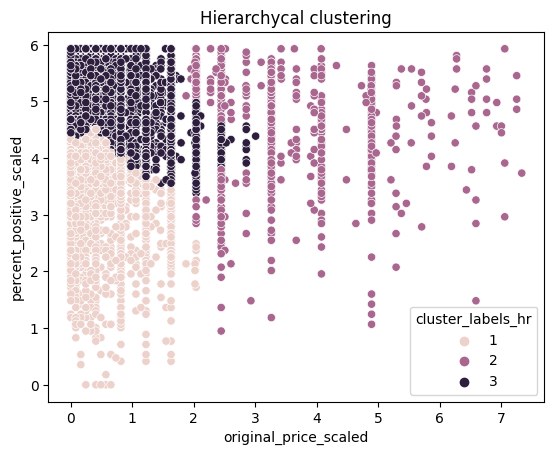

In [229]:
# Create distance matrix
distance_matrix = linkage(df[['original_price_scaled','percent_positive_scaled']], method = 'ward', metric = 'euclidean')

# Create cluster labels
df['cluster_labels_hr'] = fcluster(distance_matrix, 3, criterion='maxclust')

# Plot clusters
sns.scatterplot(x='original_price_scaled', y='percent_positive_scaled', 
                hue='cluster_labels_hr', data = df)
plt.title('Hierarchycal clustering')
plt.show()

The hierarchical clustering shows similar patterns as the KMeans model but the clusters in the KMeans models are a bit better defined, so we will choose the KMeans

Regarding the clusters we can rename using a business approach creating a new column named game_group
0 = Premium
1 = Good
2 = Excellent

Remember that most games have percent_positive value bigger than 50

In [230]:
#Drop clusters_labels_hr column
df.drop('cluster_labels_hr', axis = 1, inplace = True)
#Drop scaled columns
df.drop('percent_positive_scaled', axis = 1, inplace = True)
df.drop('original_price_scaled', axis = 1, inplace = True)

#Create categories dictionary
categories = {2:'Premium', 1:'Good', 0:'Excellent'}

#Map categories
df['cluster_labels_km'] = df['cluster_labels_km'].map(categories)

#Print result
print(df['cluster_labels_km'].head())

0    Excellent
1      Premium
2      Premium
6      Premium
7    Excellent
Name: cluster_labels_km, dtype: object


# Comparison to the business successful criteria


### Customer Question

The product manager would like to know:
- Can you use the data from 40,000 games to identify groupings of games that are most similar to each other?

### Success Criteria

Ideally, there would be no more than five groupings. Any more would make it much harder to display on the page so there would need to be a good reason to have more.

This has been done by identifying 3 groupings or categories called Premium, Excellent and Good using a 3 clusters KMeans model

In [231]:
#Our final data frame
print(df.groupby('cluster_labels_km').count())
print(df.info())
print(df.head(10))

                   name  developer  achievements  original_price  \
cluster_labels_km                                                  
Excellent          4764       4764          4764            4764   
Good               2370       2370          2370            2370   
Premium            1432       1432          1432            1432   

                   percent_positive  num_reviews  multiplayer  mature  \
cluster_labels_km                                                       
Excellent                      4764         4764         4764    4764   
Good                           2370         2370         2370    2370   
Premium                        1432         1432         1432    1432   

                   release_year  
cluster_labels_km                
Excellent                  4764  
Good                       2370  
Premium                    1432  
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8566 entries, 0 to 40728
Data columns (total 10 columns):
 #   Column    

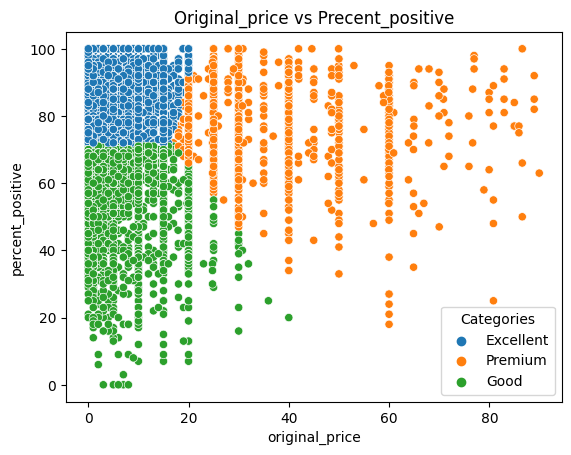

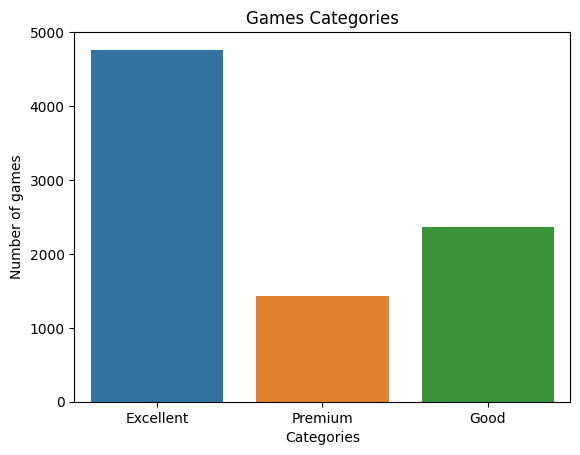

In [237]:
#Plot results
df.rename(columns ={'cluster_labels_km':'Categories'}, inplace=True)
sns.scatterplot(x = 'original_price', y = 'percent_positive', hue = 'Categories', data = df)
plt.title('Original_price vs Precent_positive')
plt.show()

sns.countplot(df['Categories'])
plt.title('Games Categories')
plt.ylabel('Number of games')
plt.show()

# Recommendations for the business for future approach

After finishing the project our business recommendations are:
- Create a task force to obtain missing values
- Maintain and update the data to the types proposed in the projects
- Improve data imputation processes as there are a large number of wrong values
- Continue improving the model by further analysis of the data
- Use of different models/methods for better clusters
- Use other variables for different possible filters, for example number of reviews and percent_positive, number_of_reviews and original_price
- Use the model as a first approach to generate these new filter categories and test and check results before implementing